In [1]:
from vit_prisma.visualization.visualize_attention import plot_attn_heads
from vit_prisma.utils.get_activations import get_activations, ActivationCacheHook, CustomAttention

from vit_prisma.models.base_vit import BaseViT
from vit_prisma.configs.InductionConfig import GlobalConfig

from vit_prisma.dataloaders.induction import InductionDataset

import torch

import copy

import numpy as np
import matplotlib.pyplot as plt


In [2]:
# Load original model
checkpoint = 0
checkpoint_path = f'/network/scratch/s/sonia.joseph/vit_prisma/induction/1_layer_attn_only/checkpoints'
file_name = f'model_{checkpoint}.pth'

config = GlobalConfig()
orig_model = BaseViT(config)

# Load dataset
testset = InductionDataset('test')
testloader = torch.utils.data.DataLoader(testset)

Loading induction dataset from cache... ../data/induction/all_test.npz


In [4]:
# Function that goes through checkpoints and plots each attention head

activations_all_cp = []
for f in os.listdir(checkpoint_path):

    orig_model = BaseViT(config)
    state_dict = torch.load(os.path.join(checkpoint_path, f), map_location=torch.device('cpu'))['model_state_dict']
    orig_model.load_state_dict(state_dict)
    
    # Replace original model's attention with hooked attention
    model = copy.deepcopy(orig_model)
    for idx, block in enumerate(model.blocks):
        model.blocks[idx].attention = CustomAttention(config)

    # Reset attention with pretrained weights from original model.
    model.load_state_dict(orig_model.state_dict())
    activations = get_activations(model, model.blocks[idx].attention.attn_scores, testloader, max_count=100, use_cuda=False)

    activations_all_cp.append(activations)

 15%|█▌        | 100/656 [00:04<00:26, 21.28it/s]


model_0.pth
model_12768.pth
model_25536.pth
model_38304.pth
model_51072.pth
model_63840.pth
model_76592.pth
model_89360.pth
checkpoint model_0.pth
Total Min: -0.08880916237831116, Total Max: 0.16248802840709686


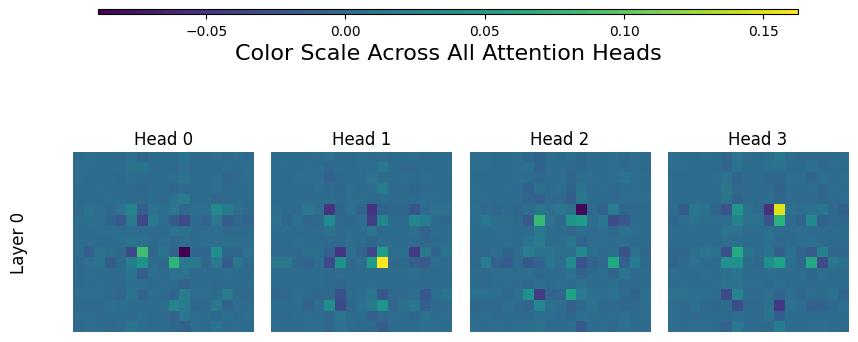

checkpoint model_12768.pth
Total Min: -0.567757785320282, Total Max: 0.5668102502822876


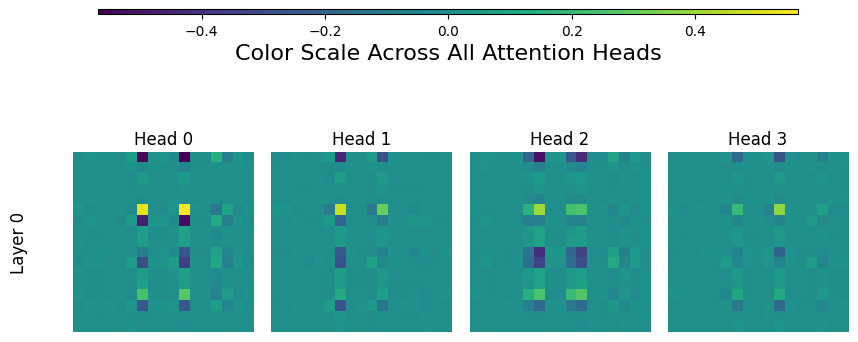

checkpoint model_25536.pth
Total Min: -14.265533447265625, Total Max: 7.807986259460449


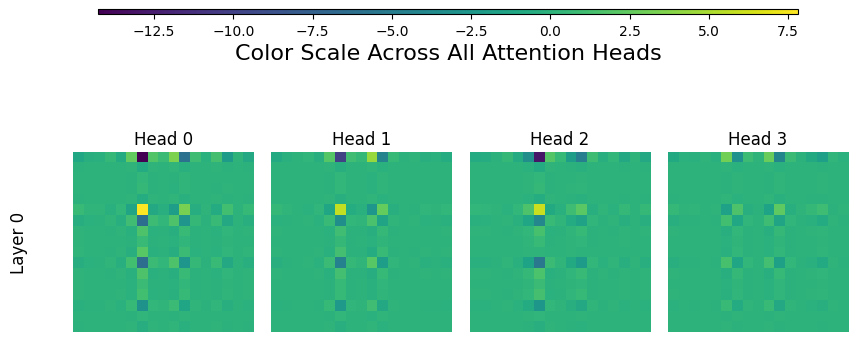

checkpoint model_38304.pth
Total Min: -15.475310325622559, Total Max: 7.86919641494751


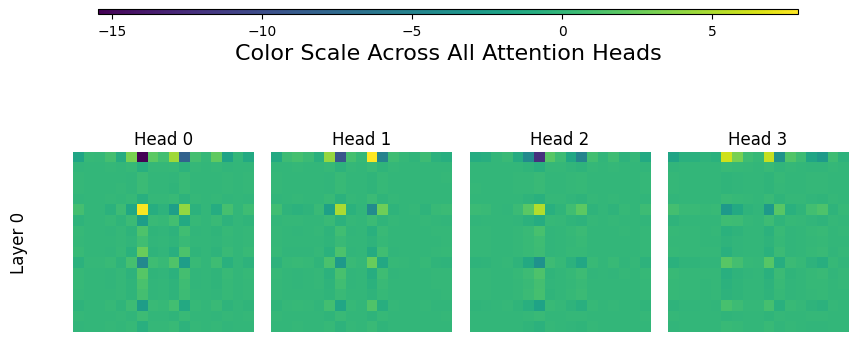

checkpoint model_51072.pth
Total Min: -14.613350868225098, Total Max: 10.354323387145996


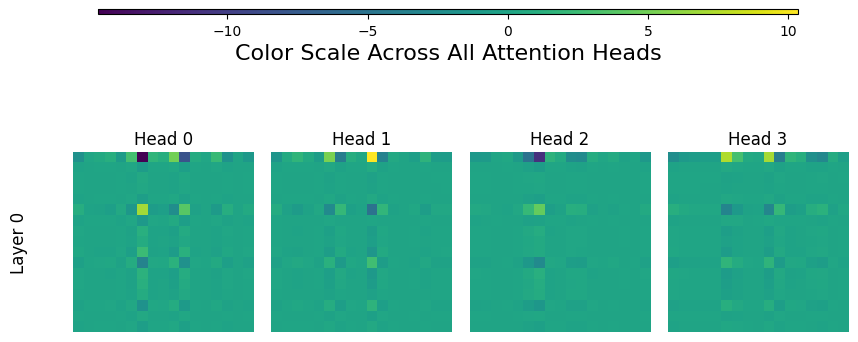

checkpoint model_63840.pth
Total Min: -14.91162109375, Total Max: 12.016060829162598


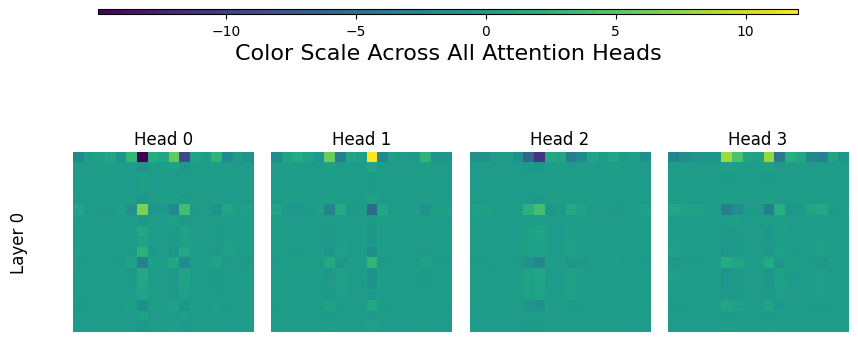

checkpoint model_76592.pth
Total Min: -15.349603652954102, Total Max: 13.406549453735352


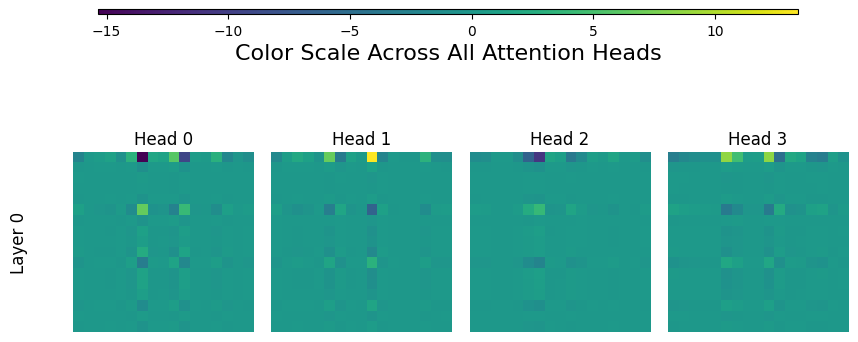

checkpoint model_89360.pth
Total Min: -16.128108978271484, Total Max: 14.542559623718262


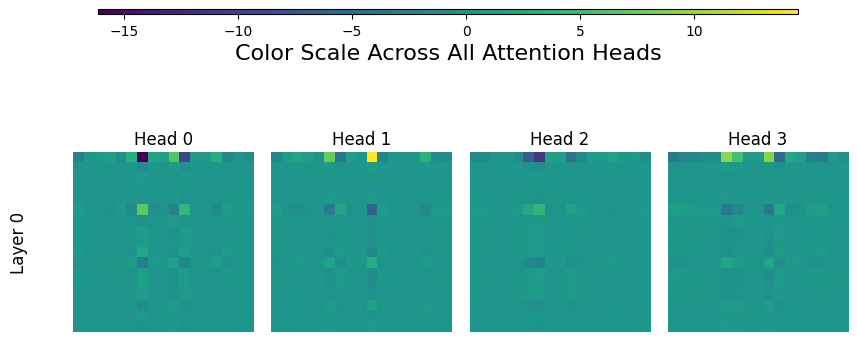

In [5]:
checkpoint_names = []
for f in os.listdir(checkpoint_path):
    print(f)
    checkpoint_names.append(f)

for cp, name in zip(activations_all_cp, checkpoint_names):
    print('checkpoint', name)
    plot_attn_heads([cp], idx=2, img_shape=17, global_min_max=True)

In [22]:
import numpy as np
import string, random, json

def convert_to_3_channels(image):
    # Check if the image has only one channel (grayscale)
    if image.shape[-1] == 1:
        # Stack the grayscale image three times along the third axis to make it 3-channel
        image = np.squeeze(image)
        image = np.stack([image, image, image], axis=-1)
    return image

def prepare_image(image):
    image = image.numpy()
    image = (image - image.min()) / (image.max() - image.min()) * 255
    image = image.astype('uint8')
    image = np.transpose(image, (1, 2, 0))
    image = convert_to_3_channels(image)
    return image

def generate_random_string(length=10):
    '''
    Helper function to generate canvas IDs for javascript figures.
    '''
    letters = string.ascii_lowercase
    return ''.join(random.choice(letters) for i in range(length))

def prepare_image(image):
    image = image.numpy()
    image = (image - image.min()) / (image.max() - image.min()) * 255
    image = image.astype('uint8')
    image = np.transpose(image, (1, 2, 0))
    image = convert_to_3_channels(image)
    return image

def flatten_into_patches(image, patch_size, image_size):
    patches = [image[i:i+patch_size, j:j+patch_size, :] for i in range(0, image_size, patch_size) for j in range(0, image_size, patch_size)]
    flattened_patches = [patch.flatten().tolist() for patch in patches]
    return flattened_patches

def normalize_attn_head(attn_head):
    min_val = np.min(attn_head)
    max_val = np.max(attn_head)
    normalized_attn_head = (attn_head - min_val) / (max_val - min_val)
    return normalized_attn_head

def plot_javascript(attn_head, image, ATTN_SCALING=20):

    num_patches = len(attn_head) 
    image_size = len(image[-1]) 
    patch_size = int(image_size // np.sqrt(num_patches-1)) 
    num_patch_width = image_size // (patch_size-1)

    print("num_patches", num_patches)
    print("patch_size", patch_size)

    canvas_img_id = generate_random_string()
    canvas_attn_id = generate_random_string()

    image = prepare_image(image)
    flattened_patches = flatten_into_patches(image, patch_size, image_size)
    normalized_attn_head = normalize_attn_head(attn_head)
    patches_json = json.dumps(flattened_patches)
    attn_head_json = json.dumps(normalized_attn_head.tolist())

    html_code = generate_html_and_js_code(patches_json, attn_head_json, canvas_img_id, canvas_attn_id, 
    image_size, patch_size, num_patch_width, num_patches, ATTN_SCALING)
    return html_code

FUNCTION_DEFINITIONS = """
function patchToImageData(patch, width, height) {{
            var imgData = new ImageData(width, height);
            var data = imgData.data;
            for (let p = 0, q = 0; p < patch.length; p += 3, q += 4) {{
                data[q] = patch[p];
                data[q + 1] = patch[p + 1];
                data[q + 2] = patch[p + 2];
                data[q + 3] = 255;
            }}
            return imgData;
        }}

"""

In [167]:

def generate_html_and_js_code(patches_json, attn_head_json, canvas_img_id, canvas_attn_id, 
    image_size, patch_size, num_patch_width, num_patches, ATTN_SCALING):
    html_code = f"""
    <div style="display: flex;">
        <canvas id="{canvas_attn_id}" width="{num_patches*ATTN_SCALING}" height="{num_patches*ATTN_SCALING}" style="width:{num_patches*ATTN_SCALING+20}px; height:{num_patches*ATTN_SCALING+20}px;"></canvas>
        <canvas id="{canvas_img_id}" width="{image_size}" height="{image_size}" style="width:{image_size+20}px; height:{image_size+20}px;"></canvas>
    </div>
    <script>
        {FUNCTION_DEFINITIONS}
        function getColor(intensity) {{
            const viridisColorMap = [
                {{pos: 0, rgb: [68, 1, 84]}} ,
                {{pos: 0.1, rgb: [72, 34, 115]}},
                {{pos: 0.2, rgb: [64, 67, 135]}},
                {{pos: 0.3, rgb: [52, 94, 141]}},
                {{pos: 0.4, rgb: [41, 120, 142]}},
                {{pos: 0.5, rgb: [32, 144, 140]}},
                {{pos: 0.6, rgb: [34, 167, 132]}},
                {{pos: 0.7, rgb: [68, 190, 112]}},
                {{pos: 0.8, rgb: [121, 209, 81]}},
                {{pos: 0.9, rgb: [189, 222, 38]}},
                {{pos: 1.0, rgb: [253, 231, 37]}}
            ];

            for (let i = 0; i < viridisColorMap.length - 1; i++) {{
                const start = viridisColorMap[i];
                const end = viridisColorMap[i + 1];
                if (intensity >= start.pos && intensity < end.pos) {{
                    const ratio = (intensity - start.pos) / (end.pos - start.pos);
                    const r = Math.floor(start.rgb[0] + ratio * (end.rgb[0] - start.rgb[0]));
                    const g = Math.floor(start.rgb[1] + ratio * (end.rgb[1] - start.rgb[1]));
                    const b = Math.floor(start.rgb[2] + ratio * (end.rgb[2] - start.rgb[2]));
                    return `rgba(${{r}}, ${{g}}, ${{b}}, 1.0)`;
                }}
            }}
            return `rgba(253, 231, 37, 1.0)`;
        }}

        var colorTokenA = 'rgba(0, 128, 128, 0.8)'; //teal
        var colorTokenB = 'rgba(255, 105, 180, 0.7)'; //pink

        var lastHighlightedCol = null;
        var lastHighlightedColSecond = null;
        var isEntireImageHighlighted = false;

        var matrixColorsImg = Array({num_patch_width}).fill().map(() => Array({num_patch_width}).fill('')); // cifar image
        var matrixColorsAttn = Array({num_patches**2}).fill().map(() => Array({num_patches**2}).fill('')); // attention head

        // PLOT CIFAR on canvasImg
        var patches = JSON.parse('{patches_json}');
        var canvasImg = document.getElementById('{canvas_img_id}');
        var ctxImg = {canvas_img_id}.getContext('2d');
        var idx = 0;
        for (let i = 0; i < {image_size}; i+= {patch_size}) {{
            for (let j = 0; j < {image_size}; j += {patch_size}) {{
                var imgData = ctxImg.createImageData({patch_size}, {patch_size});
                var data = imgData.data;
                var patch = patches[idx];

                for (let p = 0, q = 0; p < patch.length; p += 3, q += 4) {{
                    data[q] = patch[p];
                    data[q + 1] = patch[p + 1];
                    data[q + 2] = patch[p + 2];
                    data[q + 3] = 255;
    
                }}
                const row = Math.floor(i / {patch_size});
                const col = Math.floor(j / {patch_size});

                // Storing the representative color for this patch.
                // You can use the first pixel as a representative color, or calculate the average color of the patch.
                matrixColorsImg[row][col] = patch

                ctxImg.putImageData(imgData, j, i);
                ctxImg.strokeStyle = 'white';
                ctxImg.strokeRect(j, i, {patch_size}, {patch_size});

                idx++;
            }}
        }}

        // Plot attention head on canvasAttn
        var attn_head = JSON.parse('{attn_head_json}');
        var canvasAttn = document.getElementById('{canvas_attn_id}');
        var ctxAttn = {canvas_attn_id}.getContext('2d');
        for (let i = 0; i < {num_patches}; i++) {{
            for (let j = 0; j < {num_patches}; j++) {{
                var color = getColor(attn_head[i][j]);
                ctxAttn.fillStyle = color;
                ctxAttn.fillRect(j * {ATTN_SCALING}, i * {ATTN_SCALING}, {ATTN_SCALING}, {ATTN_SCALING});
                matrixColorsAttn[i][j] = color;
            }}
        }}

    // Add listeners for highlighted pixels
    canvasAttn.addEventListener('mousemove', function(event) {{

              if (lastHighlightedCol !== null) {{
            const prevrowImg = Math.floor((lastHighlightedCol - 1) / {num_patch_width});
            const prevcolImg = (lastHighlightedCol - 1) % {num_patch_width};
            var originalPatch = matrixColorsImg[prevrowImg][prevcolImg];
            var imgData = patchToImageData(originalPatch, {patch_size}, {patch_size});

            ctxImg.putImageData(imgData, prevcolImg * {patch_size}, prevrowImg * {patch_size});
            ctxImg.strokeStyle = 'white';
            ctxImg.strokeRect(prevcolImg*{patch_size}, prevrowImg*{patch_size}, {patch_size}, {patch_size});

            // Fill in attn matrix
            ctxAttn.fillStyle = matrixColorsAttn[lastHighlightedCol][lastHighlightedColSecond];
            ctxAttn.fillRect(lastHighlightedColSecond * {ATTN_SCALING}, lastHighlightedCol * {ATTN_SCALING}, {ATTN_SCALING}, {ATTN_SCALING});

        }}

        if (lastHighlightedColSecond !== null) {{
            const prevrowImg = Math.floor((lastHighlightedColSecond - 1) / {num_patch_width});
            const prevcolImg = (lastHighlightedColSecond - 1) % {num_patch_width};
            var originalPatch = matrixColorsImg[prevrowImg][prevcolImg];
            var imgData = patchToImageData(originalPatch, {patch_size}, {patch_size});

            ctxImg.putImageData(imgData, prevcolImg * {patch_size}, prevrowImg * {patch_size});
            ctxImg.strokeStyle = 'white';
            ctxImg.strokeRect(prevcolImg*{patch_size}, prevrowImg*{patch_size}, {patch_size}, {patch_size});

        }}

            var x = Math.floor(event.offsetY / {ATTN_SCALING});
            if (x === 0) {{
                lastHighlightedCol = null;
                return;
            }}
            const rowImg = Math.floor((x - 1) / {num_patch_width});
            const colImg = (x - 1) % {num_patch_width};

            var y = Math.floor(event.offsetX / {ATTN_SCALING});
            if (y === 0) {{
                lastHighlightedColSecond = null;
                return;
            }}

            const rowImgSecond = Math.floor((y - 1) / {num_patch_width});
            const colImgSecond = (y - 1) % {num_patch_width};

        if (lastHighlightedCol !== null) {{
            const prevrowImg = Math.floor((lastHighlightedCol - 1) / {num_patch_width});
            const prevcolImg = (lastHighlightedCol - 1) % {num_patch_width};
            var originalPatch = matrixColorsImg[prevrowImg][prevcolImg];
            var imgData = patchToImageData(originalPatch, {patch_size}, {patch_size});

            ctxImg.putImageData(imgData, prevcolImg * {patch_size}, prevrowImg * {patch_size});
            ctxImg.strokeStyle = 'white';
            ctxImg.strokeRect(prevcolImg*{patch_size}, prevrowImg*{patch_size}, {patch_size}, {patch_size});

            // Fill in attn matrix
            ctxAttn.fillStyle = matrixColorsAttn[lastHighlightedCol][lastHighlightedColSecond];
            ctxAttn.fillRect(lastHighlightedColSecond * {ATTN_SCALING}, lastHighlightedCol * {ATTN_SCALING}, {ATTN_SCALING}, {ATTN_SCALING});

        }}

        if (lastHighlightedColSecond !== null) {{
            const prevrowImg = Math.floor((lastHighlightedColSecond - 1) / {num_patch_width});
            const prevcolImg = (lastHighlightedColSecond - 1) % {num_patch_width};
            var originalPatch = matrixColorsImg[prevrowImg][prevcolImg];
            var imgData = patchToImageData(originalPatch, {patch_size}, {patch_size});

            ctxImg.putImageData(imgData, prevcolImg * {patch_size}, prevrowImg * {patch_size});
            ctxImg.strokeStyle = 'white';
            ctxImg.strokeRect(prevcolImg*{patch_size}, prevrowImg*{patch_size}, {patch_size}, {patch_size});

        }}

        lastHighlightedCol = x;
        lastHighlightedColSecond = y;  //

        ctxImg.fillStyle = colorTokenA;
        ctxImg.fillRect(colImg * {patch_size}, rowImg * {patch_size}, {patch_size}, {patch_size});

        ctxImg.fillStyle = colorTokenB;
        ctxImg.fillRect(colImgSecond * {patch_size}, rowImgSecond * {patch_size}, {patch_size}, {patch_size});  // Second highlighted pixel

        ctxAttn.fillStyle = 'white';
        ctxAttn.fillRect(y * {ATTN_SCALING}, x * {ATTN_SCALING}, {ATTN_SCALING}, {ATTN_SCALING});

        }}, {{ passive: true }});

        canvasAttn.addEventListener('mouseout', function() {{

            if (lastHighlightedCol !== null) {{

                const prevrowImg = Math.floor((lastHighlightedCol - 1)/ {num_patch_width});
                const prevcolImg = (lastHighlightedCol - 1) % {num_patch_width};

                if (matrixColorsImg[prevrowImg] && matrixColorsImg[prevrowImg][prevcolImg]) {{

                    // Fill in rectangle for img
                    var originalPatch = matrixColorsImg[prevrowImg][prevcolImg];
                    var imgData = patchToImageData(originalPatch, {patch_size}, {patch_size});
                    ctxImg.putImageData(imgData, prevcolImg * {patch_size}, prevrowImg * {patch_size});
                    ctxImg.strokeStyle = 'white';
                    ctxImg.strokeRect(prevcolImg * {patch_size}, prevrowImg * {patch_size}, {patch_size}, {patch_size});

                    // Fill in attn matrix
                    ctxAttn.fillStyle = matrixColorsAttn[lastHighlightedCol][lastHighlightedColSecond];
                    ctxAttn.fillRect(lastHighlightedColSecond * {ATTN_SCALING}, lastHighlightedCol * {ATTN_SCALING}, {ATTN_SCALING}, {ATTN_SCALING});
                }}
            }}

            if (lastHighlightedColSecond !== null) {{
                const prevrowImg = Math.floor((lastHighlightedColSecond - 1) / {num_patch_width});
                const prevcolImg = (lastHighlightedColSecond - 1) % {num_patch_width};

                if (matrixColorsImg[prevrowImg] && matrixColorsImg[prevrowImg][prevcolImg]) {{
                    // Fill in rectangle for img
                    var originalPatch = matrixColorsImg[prevrowImg][prevcolImg];
                    var imgData = patchToImageData(originalPatch, {patch_size}, {patch_size});
                    ctxImg.putImageData(imgData, prevcolImg * {patch_size}, prevrowImg * {patch_size});
                    ctxImg.strokeStyle = 'white';
                    ctxImg.strokeRect(prevcolImg * {patch_size}, prevrowImg * {patch_size}, {patch_size}, {patch_size});

                    // Fill in attn matrix
                    ctxAttn.fillStyle = matrixColorsAttn[lastHighlightedCol][lastHighlightedColSecond];
                    ctxAttn.fillRect(lastHighlightedColSecond * {ATTN_SCALING}, lastHighlightedCol * {ATTN_SCALING}, {ATTN_SCALING}, {ATTN_SCALING});
                }}

            }}

            lastHighlightedCol = null;
            lastHighlightedColSecond = null;  // Reset this too

        }}, {{ passive: true }});



    </script>
    """

    return html_code

In [202]:
from IPython.core.display import display, HTML

idx = 100
head_idx = 3
attn_head = activations_all_cp[-1][idx][head_idx]
html_code = plot_javascript(attn_head, image=testset[idx][0])

display(HTML(html_code))


num_patches 17
patch_size 8


In [ ]:
plt.figure()
plt.imshow(testset[idx][0].permute(1,2,0))